In [64]:
import torch
from diffusers import DDPMPipeline, DDPMScheduler
import matplotlib.pyplot as plt
import torchvision.transforms as T
import numpy as np
import random
from particles import state_space_models as ssm
import particles

In [65]:

seed = 123

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

## **Importing a pre trained model**

In [66]:
device = "cuda" if torch.cuda.is_available() else "cpu"

pipe = DDPMPipeline.from_pretrained("1aurent/ddpm-mnist").to(device)
pipe.unet.eval()

Loading pipeline components...: 100%|██████████| 2/2 [00:00<00:00,  4.97it/s]


UNet2DModel(
  (conv_in): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=32, out_features=128, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=128, out_features=128, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 32, eps=1e-05, affine=True)
          (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=128, out_features=32, bias=True)
          (norm2): GroupNorm(32, 32, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
          (conv): Conv2d(32, 32, ker

Printing example image 

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:33<00:00, 29.89it/s]


(-0.5, 27.5, 27.5, -0.5)

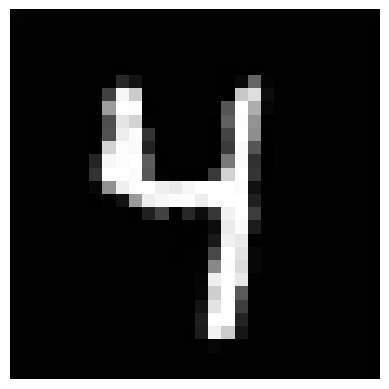

In [67]:
generator = torch.Generator(device=device).manual_seed(123)

with torch.no_grad():
    image = pipe(batch_size=1, generator= generator).images[0]

plt.imshow(image, cmap="gray")
plt.axis("off")


Inpatinting it 

(-0.5, 27.5, 27.5, -0.5)

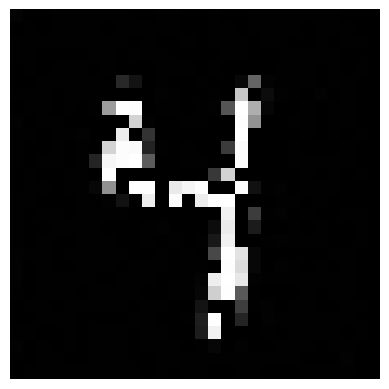

In [68]:
def create_inpainting_observation(x_true, missing_ratio=0.2, sigma_noise=0):

    mask = np.random.rand(*x_true.shape) > missing_ratio
    x_obs = np.copy(x_true)
    x_obs[~mask] = 0
    noise = np.random.normal(0, sigma_noise, size=x_true.shape)
    x_obs[mask] += noise[mask]
    
    return x_obs, mask


x0 = np.array(image).astype("float32")
y, A = create_inpainting_observation(x0, 0.4)


plt.imshow(y, cmap="gray")
plt.axis("off")

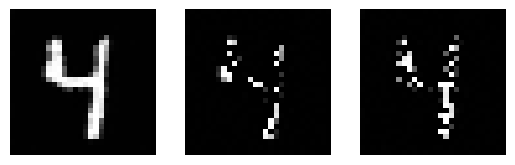

In [69]:
y_inp, A = create_inpainting_observation(x0, 0.6, 0)
y_inp_noise, A = create_inpainting_observation(x0, 0.6, 0.05)

images = [x0, y_inp, y_inp_noise]

fig, ax = plt.subplots(1, 3)
for k in range(3):
    ax[k].imshow(images[k], cmap = "gray")
    ax[k].axis("off")
  


## **Coding the SMC sampler**

Auxiliary functions : 

In [86]:
from particles import FeynmanKac as fk
from particles import distributions as dists
from particles import SMC

In [138]:
class NoiselessBackwardFK:
    def __init__(self, y, alphas, sigmas, pipeline, dx=None):
        """
        y        : observed vector in R^{dy}
        alphas   : array (alpha_0, ..., alpha_n)
        sigmas   : array (sigma_1, ..., sigma_n)
        pipeline : pretrained Hugging Face DDPMPipeline
        dx       : total dimension of x (including unobserved)
        """
        self.y = y
        self.dy = len(y)
        self.alphas = alphas
        self.sigmas = sigmas
        self.pipeline = pipeline
        self.nsteps = len(alphas) - 1
        self.T = self.nsteps
        self.dx = dx if dx is not None else self.dy 

    def done(self, *_args, **_kwargs):
        # Return True if finished, False otherwise
        return False
    
    @torch.no_grad()
    def chi(self, x, t):
        """
        Compute χ_θ^{0|t}(x_t) = ᾱ_t^{-1/2} x_t - sqrt(1 - ᾱ_t) * e_θ(x_t, t)
        """
        alpha_bar = self.alphas[t]

        # Convert x to a batch of images for UNet
        # If x is 2D (N, dx), reshape each particle
        N = x.shape[0] if len(x.shape) > 1 else 1
        img_size = int(np.sqrt(self.dx))  # assuming square images
        x_imgs = x.reshape(N, 1, img_size, img_size)  # (N, 1, H, W)

        x_tensor = torch.tensor(x_imgs, dtype=torch.float32)

        # UNet predicts noise
        t_tensor = torch.tensor([t] * N, dtype=torch.long)
        e_theta = self.pipeline.unet(x_tensor, t_tensor)[0]  # shape (N, 1, H, W)
        e_theta = e_theta.cpu().numpy().reshape(N, -1)       # flatten back to vector

        chi = x / np.sqrt(alpha_bar) - np.sqrt(1 - alpha_bar) * e_theta
        return chi

    def m(self, x_next, t):
        """
        Backward conditional mean using the Hugging Face model
        """
        chi = self.chi(x_next, t + 1)
        sigma2 = self.sigmas[t + 1]
        alpha_bar = self.alphas[t + 1]
        K_t = sigma2 / (sigma2 + 1 - alpha_bar)
        mean = K_t * np.sqrt(alpha_bar) * self.y + (1 - K_t) * chi
        return mean

    def M0(self, N):
        alpha_n = self.alphas[-1]
        sigma_n = self.sigmas[-1]
        K_n = sigma_n**2 / (sigma_n**2 + 1 - alpha_n)

        # Observed part
        mean_obs = K_n * np.sqrt(alpha_n) * self.y
        cov_obs = (1 - alpha_n) * K_n * np.eye(self.dy)
        non_inpainted_part = dists.MvNormal(loc=mean_obs, cov=cov_obs).rvs(N)

        # Unobserved part
        if self.dx > self.dy:
            mean_unobs = np.zeros(self.dx - self.dy)
            cov_unobs = np.eye(self.dx - self.dy)
            inpainted_part = dists.MvNormal(loc=mean_unobs, cov=cov_unobs).rvs(N)
            return np.hstack([non_inpainted_part, inpainted_part])
        else:
            return non_inpainted_part

    def M(self, s, xp):
        alpha_s = self.alphas[s]
        sigma_sp1 = self.sigmas[s + 1]
        K_s = sigma_sp1**2 / (sigma_sp1**2 + 1 - alpha_s)
        mean = K_s * np.sqrt(alpha_s) * self.y + (1 - K_s) * self.m(xp, s)
        cov = (1 - alpha_s) * K_s * np.eye(self.dy)

        # If xp is multiple particles, handle each row separately
        if len(xp.shape) == 2:  
            particles = np.array([dists.MvNormal(loc=m, cov=cov).rvs() for m in mean])
        else:
            particles = dists.MvNormal(loc=mean, cov=cov).rvs(len(xp))
        return particles

    def logG(self, s, xp, x):
        """
        Log potential for particle weights
        """
        if s == self.nsteps - 1:
            mean = self.m(xp, s)
            cov = (self.sigmas[self.nsteps]**2 + 1 - self.alphas[s]) * np.eye(self.dy)
            dist = dists.MvNormal(loc=mean, scale=cov)
            return dist.logpdf(np.sqrt(self.alphas[s]) * self.y)
        elif s >= 1:
            dist1 = dists.MvNormal(
                loc=self.m(xp, s),
                scale=(self.sigmas[s + 1]**2 + 1 - self.alphas[s]) * np.eye(self.dy)
            )
            dist2 = dists.MvNormal(
                loc=xp,
                scale=(1 - self.alphas[s + 1]) * np.eye(self.dy)
            )
            return dist1.logpdf(np.sqrt(self.alphas[s]) * self.y) - dist2.logpdf(np.sqrt(self.alphas[s + 1]) * self.y)
        else:
            # step s = 0
            p0 = dists.MvNormal(loc=self.m(xp, 0), scale=np.eye(self.dy))
            q10 = dists.MvNormal(scale=np.sqrt(self.alphas[1]) * self.y,
                        cov=(1 - self.alphas[1]) * np.eye(self.dy))
            return p0.logpdf(self.y) - q10.logpdf(xp)



**Example**

In [139]:
betas = torch.linspace(0.0001, 0.02, 1000)
alphas = 1 - betas
sigmas = torch.sqrt(betas)


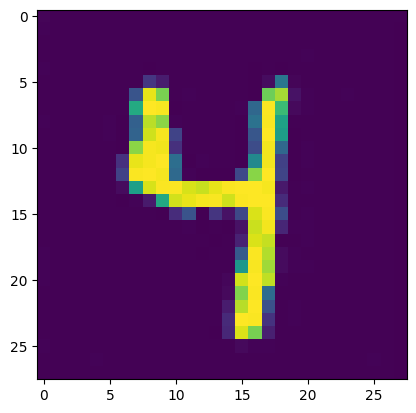

In [121]:
plt.imshow(x0)

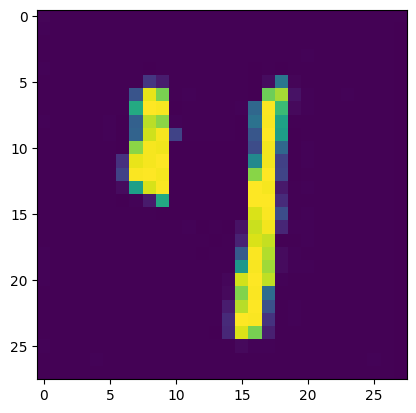

In [122]:
mask = np.ones_like(x0)
mask[10:16, 10:16] = 0  

y = x0[mask == 1]
x_masked = x0 * mask


plt.imshow(x_masked)

In [140]:
observed_flat = x0[mask == 1].flatten()  # observed pixels
unobserved_size = np.sum(mask == 0)  
dx = observed_flat.size + unobserved_size
y_obs = observed_flat

FKModel = NoiselessBackwardFK(y_obs, sigmas, alphas, pipe)


alg = SMC(
    fk=FKModel,
    N=10,  
    resampling='systematic',
)

alg.run()

AttributeError: 'NoneType' object has no attribute 'shape'

# **Whole pipeline**

In [52]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from diffusers import DDPMPipeline
from scipy.stats import multivariate_normal


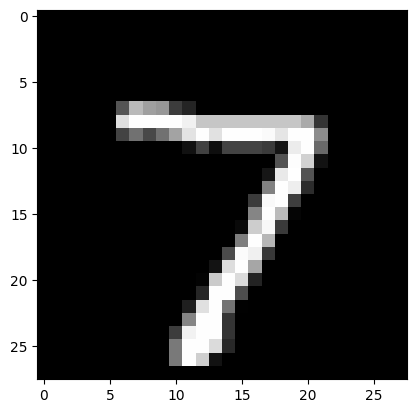

In [53]:
mnist = datasets.MNIST(root="./data", train=False, download=True, transform=transforms.ToTensor())
x0, label = mnist[0]
x0 = x0.numpy().squeeze()  

plt.imshow(x0, cmap = 'gray')

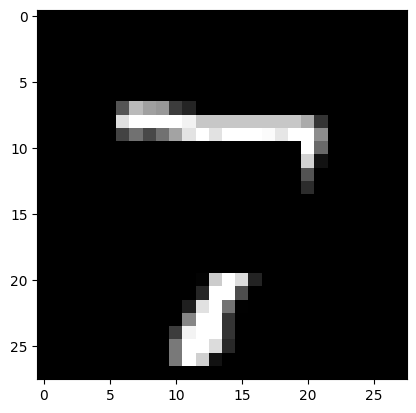

In [54]:
mask = np.ones_like(x0)
mask[10:20, 10:20] = 0

masked_img = x0 * mask
plt.imshow(masked_img, cmap ="gray")


y_obs = x0[mask == 1]
dy = len(y_obs)
dx = x0.size

In [55]:
device = "cuda" if torch.cuda.is_available() else "cpu"
pipe = DDPMPipeline.from_pretrained("1aurent/ddpm-mnist").to(device)
pipe.unet.eval()

Loading pipeline components...: 100%|██████████| 2/2 [00:00<00:00, 25.03it/s]


UNet2DModel(
  (conv_in): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=32, out_features=128, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=128, out_features=128, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 32, eps=1e-05, affine=True)
          (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=128, out_features=32, bias=True)
          (norm2): GroupNorm(32, 32, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
          (conv): Conv2d(32, 32, ker

In [56]:
num_timesteps = pipe.scheduler.num_train_timesteps
beta_start = 0.0001
beta_end = 0.02
betas = np.linspace(beta_start, beta_end, num_timesteps)
alphas = 1.0 - betas
alpha_bars = np.cumprod(alphas)
sigmas = np.sqrt(betas)

In [58]:
n_steps = 50
step_indices = np.linspace(0, num_timesteps-1, n_steps, dtype=int)
alpha_bars_sub = alpha_bars[step_indices]
sigmas_sub = sigmas[step_indices]

In [59]:
class NoiselessBackwardFK:
    def __init__(self, y, alpha_bars, sigmas, pipeline, dx):
        self.y = y
        self.dy = len(y)
        self.alpha_bars = alpha_bars
        self.sigmas = sigmas
        self.pipeline = pipeline
        self.nsteps = len(alpha_bars) - 1
        self.dx = dx

    @torch.no_grad()
    def chi(self, x, t):
        x = np.atleast_2d(x)
        N = x.shape[0]
        img_size = int(np.sqrt(self.dx))
        x_imgs = x.reshape(N, 1, img_size, img_size)
        x_tensor = torch.tensor(x_imgs, dtype=torch.float32).to(next(self.pipeline.unet.parameters()).device)
        t_tensor = torch.tensor([t]*N, dtype=torch.long).to(x_tensor.device)
        e_theta = self.pipeline.unet(x_tensor, t_tensor)[0]
        e_theta = e_theta.cpu().numpy().reshape(N, -1)
        chi_val = x / np.sqrt(self.alpha_bars[t]) - np.sqrt(1 - self.alpha_bars[t]) * e_theta
        return chi_val

    def m(self, x_next, t):
        x_next = np.atleast_2d(x_next)
        N = x_next.shape[0]
        chi = self.chi(x_next, t + 1)
        sigma2 = self.sigmas[t + 1]**2
        alpha_bar = self.alpha_bars[t + 1]
        K_t = sigma2 / (sigma2 + 1 - alpha_bar)
        mean = chi.copy()
        mean[:, :self.dy] = K_t * np.sqrt(alpha_bar) * self.y + (1 - K_t) * chi[:, :self.dy]
        return mean

    def M0(self, N):
        alpha_n = self.alpha_bars[-1]
        sigma_n = self.sigmas[-1]
        K_n = sigma_n**2 / (sigma_n**2 + 1 - alpha_n)
        mean_obs = K_n * np.sqrt(alpha_n) * self.y
        cov_obs = (1 - alpha_n) * K_n * np.eye(self.dy)
        obs_particles = np.random.multivariate_normal(mean=mean_obs, cov=cov_obs, size=N)
        if self.dx > self.dy:
            mean_unobs = np.zeros(self.dx - self.dy)
            cov_unobs = np.eye(self.dx - self.dy)
            unobs_particles = np.random.multivariate_normal(mean=mean_unobs, cov=cov_unobs, size=N)
            return np.hstack([obs_particles, unobs_particles])
        else:
            return obs_particles

    def M(self, s, xp):
        xp = np.atleast_2d(xp)
        N = xp.shape[0]
        alpha_s = self.alpha_bars[s]
        sigma_sp1 = self.sigmas[s + 1]
        K_s = sigma_sp1**2 / (sigma_sp1**2 + 1 - alpha_s)
        mean_particles = self.m(xp, s)
        cov_obs = (1 - alpha_s) * K_s * np.eye(self.dy)
        # Sample new observed part
        new_obs = np.array([
            np.random.multivariate_normal(mean=m[:self.dy], cov=cov_obs)
            for m in mean_particles
        ])
        if self.dx > self.dy:
            new_particles = np.hstack([new_obs, xp[:, self.dy:]])
        else:
            new_particles = new_obs
        return new_particles


class PseudoSMC:
    def __init__(self, fk, N=100):
        self.fk = fk
        self.N = N
        self.particles = None

    def compute_weights(self, particles, s):
        N = particles.shape[0]
        mean_particles = self.fk.m(particles, s)
        dy = self.fk.dy
        cov_val = self.fk.sigmas[s + 1]**2 + 1 - self.fk.alpha_bars[s]

        # Log-weights
        log_w = np.zeros(N)
        for i in range(N):
            diff = np.sqrt(self.fk.alpha_bars[s]) * self.fk.y - mean_particles[i, :dy]
            log_w[i] = -0.5 * (diff @ diff) / cov_val - 0.5 * dy * np.log(2 * np.pi * cov_val)

        # Stabilize: subtract max
        log_w -= np.max(log_w)

        # Exponentiate and normalize
        w = np.exp(log_w)
        if np.sum(w) == 0 or np.isnan(np.sum(w)):
            w = np.ones(N) / N
        else:
            w /= np.sum(w)
        return w

    def resample(self, particles, weights):
        indices = np.random.choice(self.N, self.N, replace=True, p=weights)
        return particles[indices]

    def run(self):
        self.particles = self.fk.M0(self.N)
        for s in reversed(range(self.fk.nsteps)):
            weights = self.compute_weights(self.particles, s)
            self.particles = self.resample(self.particles, weights)
            self.particles = self.fk.M(s, self.particles)
        return self.particles


In [ ]:
fk_model = NoiselessBackwardFK(y=y_obs, alpha_bars=alpha_bars_sub, sigmas=sigmas_sub, pipeline=pipe, dx=dx)
smc = PseudoSMC(fk=fk_model, N=50)
particles_final = smc.run()

inpainted_flat = np.mean(particles_final, axis=0)
reconstructed_img = inpainted_flat.reshape(x0.shape)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(x0, cmap='gray')
plt.title("Original MNIST")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(reconstructed_img, cmap='gray')
plt.title("Inpainted MNIST (pseudo-SMC)")
plt.axis('off')
plt.show()

